## Documentation, Imports, and Functions
*   [Numpy](https://www.numpy.org/) is an array manipulation library, used for linear algebra, Fourier transform, and random number capabilities.
*   [Pandas](https://pandas.pydata.org/) is a library for data manipulation and data analysis.
*   [CV2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.
*   [Skimage](https://scikit-image.org/) is a library which supports image processing applications on python.
*   [Matplotlib](https://matplotlib.org/) is a library which generates figures and provides graphical user interface toolkit.

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib
import matplotlib.pylab as plt
import math
import scipy.spatial.distance
%matplotlib ipympl

### nearestNeighborInterpolation

In [ ]:
# nearest Neighbor interpolation
def nearestNeighborInterpolation(warpedImage, area2check = 5):
  retWarped = np.zeros((warpedImage.shape[0],warpedImage.shape[1],3)).astype(np.uint8)
  # loop over the valid area of the warped image
  for i in range(area2check, warpedImage.shape[0] - area2check):
    for j in range(area2check, warpedImage.shape[1] - area2check):
        # check if the pixel has a valid warped value
        if warpedImage[i, j, 0] == -1:  #need to look for neighbor
            distance = area2check * area2check + 1  # assign a distance larger than any that can be found in the area to check

            # loop over all the possible neighbors
            for k in range(i - area2check,i + area2check):
                for l in range(j - area2check, j + area2check):
                    distancetested = (abs(k - i)+ abs(l - j))  # L1 distance
                    if warpedImage[k, l, 0] >= 0 and distancetested < distance:    # found a warped point , and it is closest
                        distance = distancetested
                        retWarped[i, j] = warpedImage[k, l]
        else:  #assign the valid warping
            retWarped[i, j] = warpedImage[i, j]

  return retWarped

## Project

#### Warp interface (class)
General warping interface that contains functions of creating homogrophies and transforming images from two sets of coords.

In [ ]:
class Warp:
  # computeH function from previous homework.
    # params im1_pts: nx2[]. Holds (x,y) corspondence points of image1.
    # params im2_pts: nx2[]. Holds (x,y) corspondence points of image2.
    # return H: a 3x3[] homography.
    def __computeH__(self, im1_pts, im2_pts):

      if (len(im1_pts) != len(im2_pts)):
        return -1;


      # Helper function to setup the A matrix.
      def setupA(im1_pts, im2_pts):
        # Create an array as a boiler plate, with 2n rows and 8 columns for 8 DOF
        numberOfPoints = len(im1_pts)
        A = -np.ones((numberOfPoints*2, 8))

        i = 0 # reference for each set of points
        j = 0 # helper pointer to assign x, y mat setup
        while (i < numberOfPoints):
          x1, y1 = im1_pts[i]
          x2, y2 = im2_pts[i]

          # setup each coorspondence points "sub matrix"
          xSetup = np.array([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1])
          ySetup = np.array([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1])

          A[i + j] = xSetup
          A[i + j + 1] = ySetup
          j = i + 1
          i = i + 1;

        return A


      # Helper function that creates b.just flattens set of points and transposes them.
      # params points: nx2[], Holds (x,y) coords
      def setupb(points):
        ret = np.array([np.ravel(points)])
        return np.transpose(ret)


      A = setupA(im1_pts, im2_pts)
      b = setupb(im2_pts)
      A_trans = np.transpose(A)

      pseudoInv_lhs = np.linalg.inv(np.matmul(A_trans, A))
      pseudoInv_rhs = np.matmul(A_trans, b)

      # to flatten the returned array, we use ravel.
      t = np.ravel(np.matmul(pseudoInv_lhs, pseudoInv_rhs))
      # THE HOMOGRAPHY!!!
      return np.array([[t[0], t[1], t[2]], [t[3], t[4], t[5]], [t[6], t[7], 1]])


    # warpImage function from previous homework.
    # coordinates: (xmin: int, xmax: int, ymin: int, ymax: int)
    def __warpImage__(self, H, coordinates):
      xmin, xmax, ymin, ymax = coordinates

      # Make an array of [0, 1, ..., image.height()]
      i = np.linspace(0, self.image.shape[0]-1, self.image.shape[0]).astype(int)
      # Make an array of [0, 1, ..., image.width()]
      j = np.linspace(0, self.image.shape[1]-1, self.image.shape[1]).astype(int)
      # And here we create the row and column numbers of the image.
      yv, xv = np.meshgrid(i, j)
      # number of points on the grid, image.width() * image.height().
      numpoints = xv.ravel().shape[0]

      # extract the color channels
      r = self.image[yv.ravel(), xv.ravel(), 0]
      g = self.image[yv.ravel(), xv.ravel(), 1]
      b = self.image[yv.ravel(), xv.ravel(), 2]

      # all the values of x coordinates as a row
      x_cord = xv.ravel().reshape((1,numpoints))
      # all the values of y coordinates as a row
      y_cord = yv.ravel().reshape((1,numpoints))


      # and finally, the result of the grid are "vector" locations. in homogeneous
      grid = np.concatenate((x_cord, y_cord, np.ones((1,numpoints))),axis=0)

      # TRANSFORMING THE IMAGE
      # Apply the perspective matrix to the set of points of image.
      newgrid = np.matmul(H, grid)
      newgrid[0] = newgrid[0, :] / newgrid[2, :]    # newgrid[0], newgrid[1]
      newgrid[1] = newgrid[1, :] / newgrid[2, :]    # homo -> hetero

      # create 2D array of -1's representing empty image
      warped = -np.ones((xmax + 1, ymax + 1, 3)).astype(np.int16)
      # approximations, considering just the int values.
      newgrid2 = newgrid.round().astype(np.int64)

      # Defining new range of values.
      validX = np.bitwise_and(newgrid[0, :] >= xmin, newgrid2[0, :] < xmax)
      validY = np.bitwise_and(newgrid[1, :] >= ymin, newgrid2[1, :] < ymax)
      valid =  np.bitwise_and(validX, validY)

      # Assign channels repsective colors
      warped[newgrid2[1, valid], newgrid2[0, valid], 0] = r[valid]
      warped[newgrid2[1, valid], newgrid2[0, valid], 1] = g[valid]
      warped[newgrid2[1, valid], newgrid2[0, valid], 2] = b[valid]

      return warped;

### Interactive

An interactive matplotlib graph where a user can click 4 corners on an image, and the image will transform/warp to that new space.

I wanted to do something interactive and creative than just a user typing in coordinate points to transform too.

#### InteractiveWarp class
Big shoutout to this documentation: https://matplotlib.org/stable/users/explain/event_handling.html

In [ ]:
class InteractiveWarp(Warp):
    # constructor.
    def __init__(self, image, coords, pointsNeeded, size):
        self.image = np.copy(image.astype(np.float32))
        self.coords = coords
        self.counter = 0
        self.pointsNeeded = pointsNeeded
        self.pointFlag = False
        self.size = size

        self.xs = list(coords.get_xdata())
        self.ys = list(coords.get_ydata())
        self.cid = coords.figure.canvas.mpl_connect('button_press_event', self)


    #region PRIVATE VARIABLES

    # Runs when plot is clicked.
    def __call__(self, event):
      # Check if click was in bounds of click listener.
      if self.pointFlag != True:
        if  (event.inaxes != self.coords.axes):
          return

        # Add the point selected to the list.
        self.counter = self.counter + 1
        self.xs.append(round(event.xdata))  # no floats >:(
        self.ys.append(round(event.ydata))
        print(event.xdata, event.ydata)

        # When total points are fulfilled run the program.
        if self.counter == self.pointsNeeded:
          self.__createNewView__()

        # do nothing when flag has been fulfilled.
        else:
          return

    def __createNewView__(self):
      self.pointFlag = True
      # points were initialized with 0 at start of list. pop it from list
      self.xs.pop(0); self.ys.pop(0)

      ###   FUN BEGINS   ########################################################
      # Create a set of readable points for the homography transform
      coordChoice = np.array(list(zip(self.xs, self.ys)))
      coordsToWarpTo = np.array([[0, 0], [self.size, 0], [self.size, self.size], [0, self.size]])

      print("coordChoice: ", coordChoice)
      print("coordsToWarpTo: ", coordsToWarpTo)

      # create the homography from selected points to new points
      warpHomography = self.__computeH__(coordChoice, coordsToWarpTo)
      warpedImage = self.__warpImage__(warpHomography, (0, self.size, 0, self.size))

      plt.clf()

      # smooth result with nearest neighbor.
      aaImage = nearestNeighborInterpolation(warpedImage)

      plt.imshow(aaImage)

    #endregion


    #region PUBLIC VARIABLES

    # setup plot to have image instanced over it.
    def setupPlotImage(self, displayImage):
      # make the shape of the plot the size of the image
      plt.xlim(0, displayImage.shape[1])
      plt.ylim(displayImage.shape[0], 0)

      # add an image ontop of figure.
      plt.imshow(displayImage)

    #endregion

#### **TO USE:**
Click on 4 points within the plot image to transform into another space.

* Image 1, select corners of "center-area" of the tile flooring to reveal pattern.
* Image 1, select 4 corner area of stain glass or statue to reveal detail.

* Image 2, select 4 corners of any painting in the meausum to reveal painting.

REMEMBER: Top-left, top-right, bottom-right, bottom-left to properly orientate image.



When 4 points are selected, just give it a moment to warp and anti-alias! (:

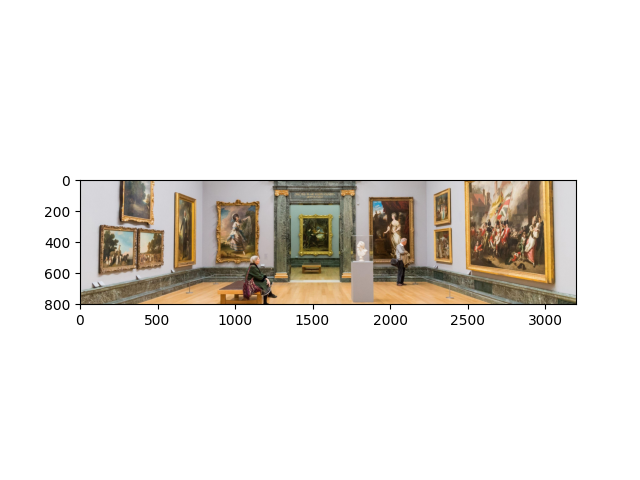

In [ ]:
# Setup plot
fig, ax = plt.subplots()
coords, = ax.plot([0], [0])
image1 = io.imread("https://i.imgur.com/DDfxZke.jpg")
image2 = io.imread("https://media.tacdn.com/media/attractions-content--1x-1/0f/45/f8/44.jpg")
numberOfPoints = 4
size = 350


# the image here will be the image used for the interactive.
image = image2

# Instantiate interactive window to select points and create a warped image.
points = InteractiveWarp(image, coords, numberOfPoints, size)
points.setupPlotImage(image)